In [3]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import json

In [4]:
# file paths
higgs_time = 'dataset/higgs-activity_time.txt'
runtime_result = 'results/mt-result-DL-runtime.json'
heuristic_result = 'results/mt-result-heuristic-DT-final.json'
celf_dt_result = 'results/mt-result-algorithm-DT-final.json'
celf_pa_result = 'results/mt-result-algorithm-PA-final.json'
celf_dl_result = 'results/mt-result-algorithm-DL-final.json'
celf_rt_dt = 'results/rt-result-algorithm-DT-final.json'
celf_dt_with_rt = 'results/mt-result-algorithm-DT-with-rt.json'
compare_algo = 'results/mt-result-compare-algos-DT.json'
cost_mt = 'dataset/cost-MT.json'

In [5]:
def normalize_numbers(numbers, max_value):
    """
    Normalizes a list of numbers to the range [0, 1].
    """
    if not numbers:
        return []

    min_value = 0

    if min_value == max_value:
        return [0.0] * len(numbers)

    return [(x - min_value) / (max_value - min_value) for x in numbers]

## Show outbreak of the original dataset

<Figure size 1500x700 with 0 Axes>

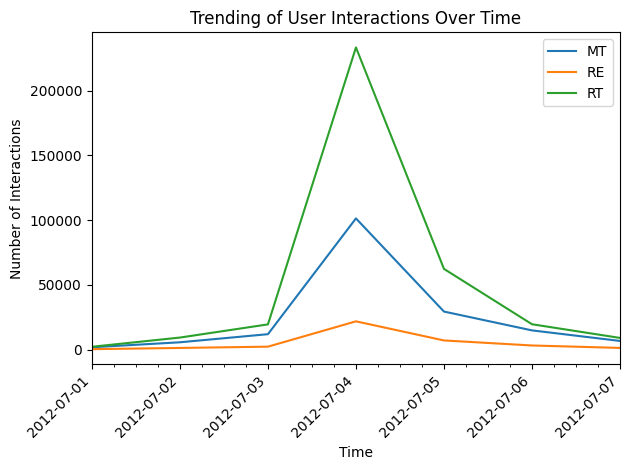

In [6]:
def read_line(line):
    try:
        user1, user2, timestamp, interaction = line.split()
        return {'user1': user1, 'user2': user2, 'timestamp': int(timestamp), 'interaction': interaction}
    except ValueError:
        print(line)
        return None

with open(higgs_time, 'r') as file:
    lines = file.readlines()

data = [read_line(line) for line in lines]
df = pd.DataFrame([d for d in data if d is not None])

df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')

# Set the range for timestamp
start_timestamp = pd.to_datetime(1341100972, unit='s')
end_timestamp = pd.to_datetime(1341705593, unit='s')
df = df[(df['timestamp'] >= start_timestamp) & (df['timestamp'] <= end_timestamp)]

# Resample data to larger time bins if needed (e.g., 'D' for day)
df['time_bin'] = df['timestamp'].dt.floor('D')

# Group by the resampled time bins and interaction type
interaction_counts = df.groupby(['time_bin', 'interaction']).size().unstack().fillna(0)

# Set the figure size for better readability
plt.figure(figsize=(15, 7))

# Plot the data
interaction_counts.plot(kind='line')

# Title and labels
plt.title('Trending of User Interactions Over Time')
plt.xlabel('Time')
plt.ylabel('Number of Interactions')

# Set major and minor locators and formatters for the x-axis
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))  # Adjust interval as needed
plt.gca().xaxis.set_minor_locator(mdates.HourLocator(interval=6)) # Adjust interval as needed
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Rotate and align the tick labels so they look better
plt.xticks(rotation=45, ha='right')

# Legend and layout
plt.legend()
plt.tight_layout()

# Display the plot
plt.show()

## Result graphs

### Runtime

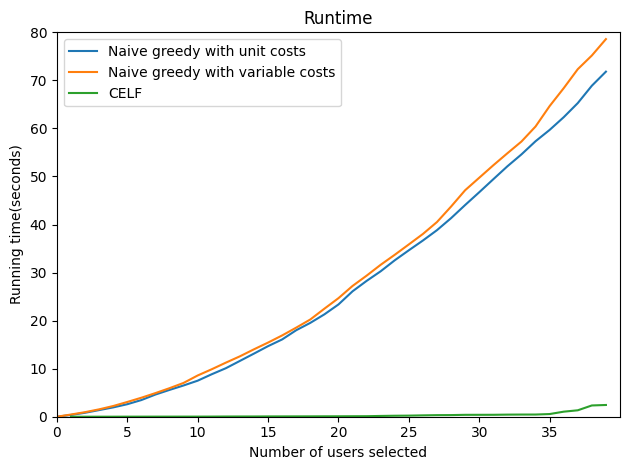

In [7]:
# DL
# 40 selected nodes
# The runtime range for uc-greedy is from 5740(initial time) - 5812
# The runtime range for cb-greedy is from 5829 - 5907
# The runtime range for cb-greedy is from 2900 - 2903

with open(runtime_result, 'r') as f:
  data = json.loads(f.read())

nodes_number = {}
runtime = {}
for d in data:
  nodes_number[d['algo']] = [int(n) - 1 for n in d['runtime'].keys()]

  runtime[d['algo']] = [r['runtime'] for r in d['runtime'].values()]

# Get relative runtime
for algo in runtime:
  for i in range(1, len(runtime[algo])):
    runtime[algo][i] = runtime[algo][i] - runtime[algo][0]
  runtime[algo][0] = 0

plt.plot(nodes_number['greedy-UC'], runtime['greedy-UC'], label='Naive greedy with unit costs')
plt.xticks(range(0, len(nodes_number['greedy-UC']), 5), nodes_number['greedy-UC'][::5])

plt.plot(nodes_number['greedy-CB'], runtime['greedy-CB'], label='Naive greedy with variable costs')
plt.plot(nodes_number['celf'], runtime['celf'], label='CELF')

plt.xlim([0, 40])
plt.ylim([0, 80])

plt.title('Runtime')
plt.xlabel('Number of users selected')
plt.ylabel('Running time(seconds)')
plt.legend()

plt.tight_layout()
plt.show()

### Comparison with heuristics

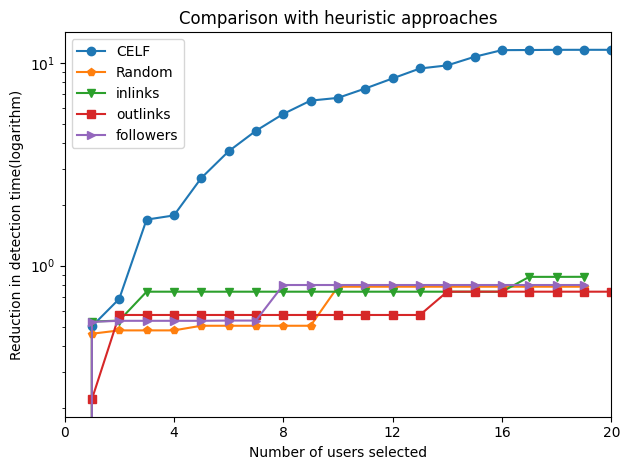

In [8]:
with open(celf_dt_result, 'r') as f:
  data = json.loads(f.read())

celf_result = data[0]

# runtime = {}
nodes_number_celf = list(celf_result['runtime'].keys())
celf_reward = [r['reward'] for r in celf_result['runtime'].values()]
# celf_reward = celf_reward

with open(heuristic_result, 'r') as f:
  data = json.loads(f.read())

nodes_number = {}
reward = {}
for d in data:
  nodes_number[d['algo']] = [n for n in d['reward'].keys()][:20]
  reward[d['algo']] = [r for r in d['reward'].values()][:20]

plt.plot(nodes_number_celf, celf_reward, marker='o', label='CELF')

plt.plot(nodes_number['random'], reward['random'], marker='p', label='Random')
plt.plot(nodes_number['inlinks'], reward['inlinks'], marker='v', label='inlinks')
plt.plot(nodes_number['outlinks'], reward['outlinks'], marker='s', label='outlinks')
plt.plot(nodes_number['followers'], reward['followers'], marker='>', label='followers')
plt.xticks(range(0, len(nodes_number_celf), 4), nodes_number_celf[::4])
plt.xlim([0, 20])
# plt.ylim(bottom=0)

plt.title('Comparison with heuristic approaches')
plt.xlabel('Number of users selected')
plt.ylabel('Reduction in detection time(logarithm)')
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.show()

### Comparison between rewards and costs


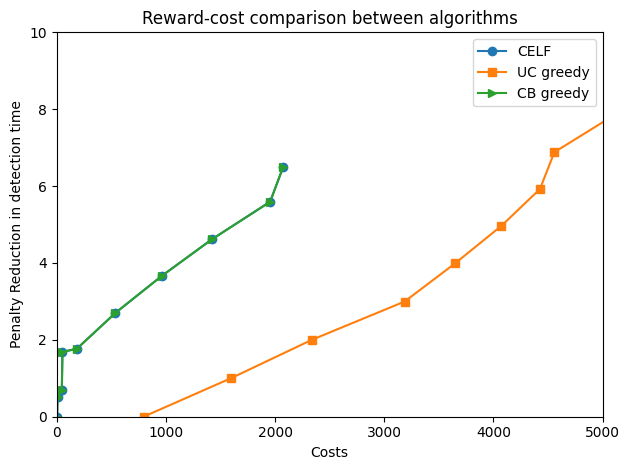

In [9]:
with open(compare_algo, 'r') as f:
  data = json.loads(f.read())

with open(cost_mt, 'r') as f:
  cost = json.load(f)

cost = {int(key): value for key, value in cost.items()}
cb_greedy = data[0]
uc_greedy = data[1]
celf = data[2]

celf_cost = [cost[n] for n in celf['placement'][:10]]
uc_cost = [cost[n] for n in uc_greedy['placement'][:10]]
cb_cost = [cost[n] for n in cb_greedy['placement'][:10]]

for i in range(1, len(celf_cost)):
  celf_cost[i] += celf_cost[i-1]
  uc_cost[i] += uc_cost[i-1]
  cb_cost[i] += cb_cost[i-1]

celf_rewards = list(celf['reward'].values())[:10]
uc_rewards = list(uc_greedy['reward'].values())[:10]
cb_rewards = list(cb_greedy['reward'].values())[:10]

plt.plot(celf_cost, celf_rewards, marker='o', label='CELF')
plt.plot(uc_cost, uc_rewards, marker='s', label='UC greedy')
plt.plot(cb_cost, cb_rewards, marker='>', label='CB greedy')

plt.xlim([0, 5000])
plt.ylim([0, 10])

plt.title('Reward-cost comparison between algorithms')
plt.xlabel('Costs')
plt.ylabel('Penalty Reduction in detection time')
# plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.show()

### Comparison with three objective functions

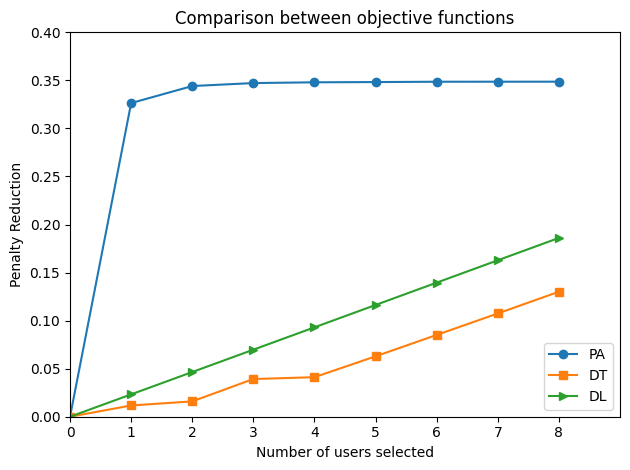

In [10]:
with open(celf_pa_result, 'r') as f:
  data = json.loads(f.read())

celf_result_pa = data[0]

r = 9
nodes_number_celf_pa = list(celf_result_pa['runtime'].keys())[:r]
celf_reward_pa = [r['reward'] for r in celf_result_pa['runtime'].values()][:r]
celf_reward_pa = normalize_numbers(celf_reward_pa, 43)

with open(celf_dt_result, 'r') as f:
  data = json.loads(f.read())

celf_result_dt = data[0]

nodes_number_celf_dt = list(celf_result_dt['runtime'].keys())[:r]
celf_reward_dt = [r['reward'] for r in celf_result_dt['runtime'].values()][:r]
celf_reward_dt = normalize_numbers(celf_reward_dt, 43)

with open(celf_dl_result, 'r') as f:
  data = json.loads(f.read())

celf_result_dl = data[0]

nodes_number_celf_dl = list(celf_result_dl['runtime'].keys())[:r]
celf_reward_dl = [r['reward'] for r in celf_result_dl['runtime'].values()][:r]
# celf_reward_dt = normalize_numbers(celf_reward_dt, 43)

plt.plot(nodes_number_celf_pa, celf_reward_pa, marker='o', label='PA')
plt.plot(nodes_number_celf_dt, celf_reward_dt, marker='s', label='DT')
plt.plot(nodes_number_celf_dl, celf_reward_dl, marker='>', label='DL')

plt.xlim([0, 9])
plt.ylim([0, 0.4])

plt.title('Comparison between objective functions')
plt.xlabel('Number of users selected')
plt.ylabel('Penalty Reduction')
# plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.show()

### Comparison between mentions and retweets

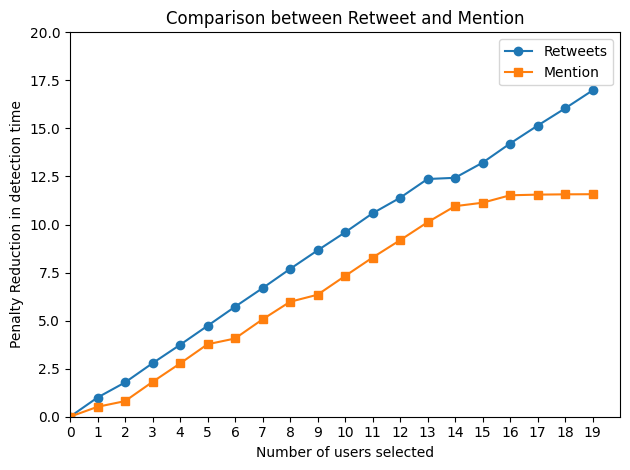

In [16]:
with open(celf_rt_dt, 'r') as f:
  data = json.loads(f.read())

celf_result_rt = data[0]

r = 20
nodes_number_celf_rt = list(celf_result_rt['runtime'].keys())[:r]
celf_reward_rt = [r['reward'] for r in celf_result_rt['runtime'].values()][:r]
# celf_reward_pa = normalize_numbers(celf_reward_pa, 43)

with open(celf_dt_with_rt, 'r') as f:
  data = json.loads(f.read())

celf_result_dt = data[0]

nodes_number_celf_dt = list(celf_result_dt['runtime'].keys())[:r]
celf_reward_dt = [r['reward'] for r in celf_result_dt['runtime'].values()][:r]
# celf_reward_dt = normalize_numbers(celf_reward_dt, 43)

plt.plot(nodes_number_celf_rt, celf_reward_rt, marker='o', label='Retweets')
plt.plot(nodes_number_celf_dt, celf_reward_dt, marker='s', label='Mention')

plt.xlim([0, 20])
plt.ylim([0, 20])

plt.title('Comparison between Retweet and Mention')
plt.xlabel('Number of users selected')
plt.ylabel('Penalty Reduction in detection time')
plt.legend()
plt.tight_layout()
plt.show()

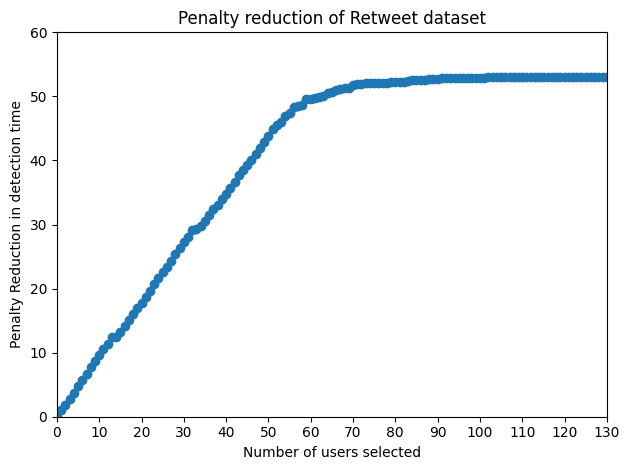

In [17]:
with open(celf_rt_dt, 'r') as f:
  data = json.loads(f.read())

celf_result_rt = data[0]

# r = 20
nodes_number_celf_rt = list(celf_result_rt['runtime'].keys())
celf_reward_rt = [r['reward'] for r in celf_result_rt['runtime'].values()]
# celf_reward_pa = normalize_numbers(celf_reward_pa, 43)
plt.xticks(range(0, len(nodes_number_celf_rt), 10), nodes_number_celf_rt[::10])

plt.plot(nodes_number_celf_rt, celf_reward_rt, marker='o')

plt.xlim([0, 130])
plt.ylim([0, 60])

plt.title('Penalty reduction of Retweet dataset')
plt.xlabel('Number of users selected')
plt.ylabel('Penalty Reduction in detection time')
plt.tight_layout()
plt.show()